In [55]:
%matplotlib inline
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeYorktown
import matplotlib.pyplot as plt
import pandas as pd

In [56]:
device_backend = FakeYorktown()
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates

Mathematica-optimised angles:
$\theta_0 = -1.5708,\\
\theta_1 = 6.75662\text{e}-9,\\
\theta_2 = -0.979924,\\
\theta_3 = -3.14159,\\
\theta_4 = -1.51454\text{e}-8,\\
\theta_5 = 3.14159,\\
\theta_6 = 3.14159,\\
\theta_7 = 3.14159$

In [57]:
hyperparams = [-np.pi/2, 0, -0.979924, -np.pi, 0, np.pi, np.pi, np.pi]
shots = 200000
U = 4
mu = U/2
eps2 = 0
V = 0.745356

In [58]:
def fresh_circuit(theta):
    # Construct quantum circuit
    circ = QuantumCircuit(4, 4)
    circ.ry(theta[0],0)
    circ.ry(theta[1],1)
    circ.ry(theta[2],2)
    circ.ry(theta[3],3)
    circ.cx(0,1)
    circ.cx(1,2)
    circ.cx(2,3)
    circ.ry(theta[4],0)
    circ.ry(theta[5],1)
    circ.ry(theta[6],2)
    circ.ry(theta[7],3)
    return circ

In [59]:
def get_sigma(basis,index, result_noise):
    if basis == 'x':
        result = result_noise[0]
    elif basis == 'y':
        result = result_noise[1]
    elif basis == 'z':
        result = result_noise[2]

    vec = np.array([(-1)**(sum([int(n[i]) for i in index])) for n in result.keys()])
    result = np.array(list(result.values()))
    return (np.dot(result,vec)/shots)

In [60]:
circ_x = QuantumCircuit(2,2)
circ_y = QuantumCircuit(2,2)
circ_z = QuantumCircuit(2,2)
circ_x.x(0)
circ_y.x(0)
circ_y.h([0,1])
circ_z.x(0)
circ_z.sdg([0,1])
circ_z.h([0,1])
circ_x.measure([0,1],[0,1])
circ_y.measure([0,1],[0,1])
circ_z.measure([0,1],[0,1])
simulator = Aer.get_backend('statevector_simulator')
result_noise = execute([circ_x, circ_y, circ_z], backend=simulator).result().get_statevector(circ_z)

In [71]:
def calc_H(th):
    # Select the QasmSimulator from the Aer provider

    circ_z = fresh_circuit(th)
    circ_z.measure(list(range(4)),list(range(4)))
    circ_x = fresh_circuit(th)
    circ_x.h([0,1,2,3])
    circ_x.measure(list(range(4)),list(range(4)))
    circ_y = fresh_circuit(th)
    circ_y.sdg([0,1,2,3])
    circ_y.h([0,1,2,3])
    circ_y.measure(list(range(4)),list(range(4)))
    # Execute noisy simulation and get counts
    #simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    result_noise = execute([circ_x, circ_y, circ_z], simulator).result().get_counts()
    
    """
    result_noise = execute([circ_x, circ_y,circ_z], simulator,
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates,
                           shots=shots).result().get_counts()
    """
    #reverse the order of qubits to something that makes sense
    rn = list(map(lambda x: dict(zip(list(map(lambda y: y[::-1],x.keys())), x.values() )), result_noise))

    
    H1 = U*get_sigma('z',[0,2],rn)/4 + (mu/2 - U/4)*(get_sigma('z',[0],rn) + get_sigma('z',[2],rn))
    #H2 = eps2*(sigma['z'][1]+sigma['z'][3])/2
    H2 = 0
    H3 = V*(get_sigma('x',[0,1],rn) + get_sigma('y',[0,1],rn))/2
    H4 = V*(get_sigma('x',[2,3],rn) + get_sigma('y',[2,3],rn))/2
    H = H1-H2+H3+H4
    return H

In [62]:
deg = np.pi/180
lb=-1.5*deg
ub=1.5*deg
deltas = np.mgrid[lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j].reshape(8,-1).T
params = np.array(list(map( lambda x: x+hyperparams,deltas)))
results = np.zeros((len(deltas),1), dtype=np.float64)
for i in range(len(deltas)):
    results[i] = calc_H(params[i])
pd.DataFrame(np.append(deltas, results, axis=1),
             columns=['dth'+str(i) for i in range(1,9)]+['H']).to_csv('statevector_results.csv',index=False)


KeyboardInterrupt: 

In [66]:
df = pd.DataFrame(np.append(deltas, results, axis=1),columns=['dth'+str(i) for i in range(1,9)]+['H'])

In [78]:
df

,dth1,dth2,dth3,dth4,dth5,dth6,dth7,dth8,H
0,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-1.596575
1,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.01309,-1.596522
2,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,0.00000,-1.597126
3,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,0.01309,-1.602612
4,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,-0.02618,0.02618,-1.597657
...,...,...,...,...,...,...,...,...,...
17397,-0.02618,-0.01309,-0.02618,0.00000,0.02618,-0.02618,0.02618,0.00000,-1.597317
17398,-0.02618,-0.01309,-0.02618,0.00000,0.02618,-0.02618,0.02618,0.01309,-1.599958
17399,-0.02618,-0.01309,-0.02618,0.00000,0.02618,-0.02618,0.02618,0.02618,-1.595969
17400,-0.02618,-0.01309,-0.02618,0.00000,0.02618,-0.01309,-0.02618,-0.02618,-1.595509


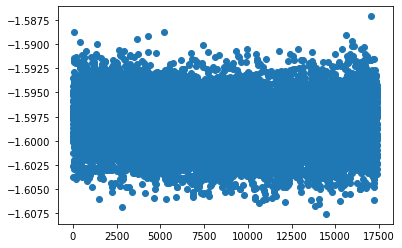

In [99]:
plt.scatter(list(range(17402)), df.H)

In [73]:
"""
loop time = 1.079375 sec

"""

#only with decoherent errors: -1.5969232194799998
data = df
mean = np.mean(data, axis=0)
cov = np.cov(data, rowvar=0)

In [75]:
cov

array([[ 4.81510156e-35,  1.16877307e-35, -2.18170973e-34,
         2.40174012e-34,  1.62919883e-35,  8.12662526e-36,
        -6.99908022e-36, -3.84887155e-36, -3.22475116e-34],
       [ 1.16877307e-35,  1.57112719e-05, -3.14225438e-05,
        -1.65777348e-05, -1.73292588e-06, -4.59755846e-07,
        -3.53658343e-08, -2.65243757e-08,  6.74922355e-07],
       [-2.18170973e-34, -3.14225438e-05,  3.70563212e-04,
         3.31554697e-05,  3.46585176e-06,  9.19511692e-07,
         7.07316686e-08,  5.30487515e-08, -6.30026299e-06],
       [ 2.40174012e-34, -1.65777348e-05,  3.31554697e-05,
         3.36500609e-04, -2.07951106e-07, -5.51707015e-08,
        -4.24390012e-09, -3.18292509e-09, -3.51057613e-06],
       [ 1.62919883e-35, -1.73292588e-06,  3.46585176e-06,
        -2.07951106e-07,  3.40762545e-04, -1.02985310e-06,
        -7.92194689e-08, -5.94146016e-08,  1.90593318e-07],
       [ 8.12662526e-36, -4.59755846e-07,  9.19511692e-07,
        -5.51707015e-08, -1.02985310e-06,  3.431854